<a href="https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/partialPeriodicPattern/basic/GThreePGrowth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Partial Periodic Frequent patterns in Temporal Databases using GThreePGrowth

This tutorial has two parts. In the first part, we describe the basic approach to find Partial Periodic Frequent patterns in a temporal database using the GThreePGrowth algorithm. In the final part, we describe an advanced approach, where we evaluate the GThreePGrowth algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=dda569ba697e761924cda4a12b31514791d76738363a6b92d7fd74857e769124
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=2e15281ac1387c8071f2e5c606fd9b8f3c64c4b33fffa5b838e5a26b962cdc6f
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-09-07 06:53:49--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M  1.11MB/s    in 6.4s    

2023-09-07 06:53:58 (698 KB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Partial Periodic Frequent patterns using GThreePGrowth

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.TemporalDatabase as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.TemporalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

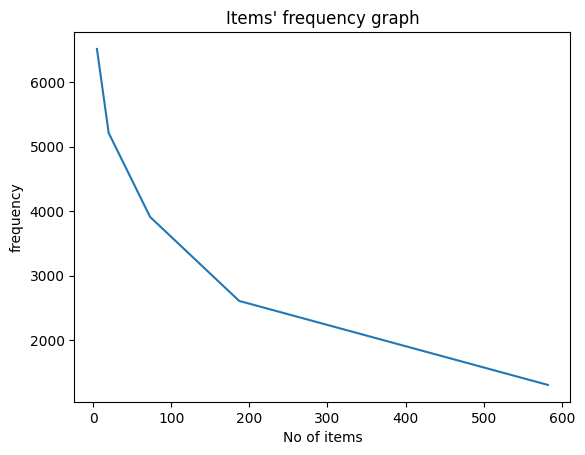

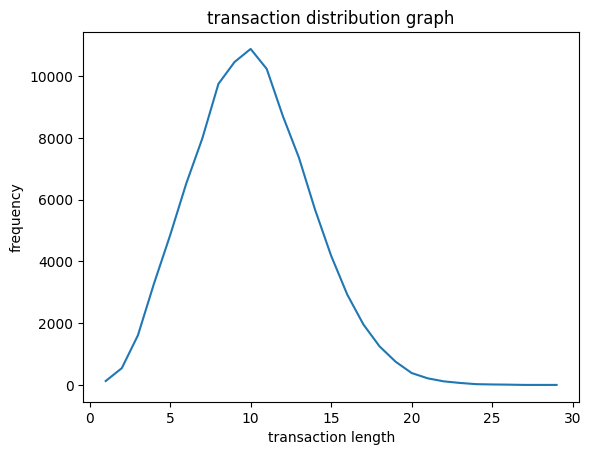

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minimumSupportCount = 100  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
PeriodCount = 500  #PeriodCount is specified in count. However, the users can also specify PeriodCount between 0 and 1.
relativePSCount=0.2 #relativePSCount is specified in count. However, the users can also specify different relativePSCount value.

### Step 4: Mining Partial Periodic Frequent patterns using GThreePGrowth

In [10]:
from PAMI.partialPeriodicPattern.basic import GThreePGrowth  as alg #import the algorithm

obj = alg.GThreePGrowth(iFile=inputFile, minPS=minimumSupportCount, period=PeriodCount, relativePS=relativePSCount, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('partialPeriodicFrequentPatternsAtMinSupCount100.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

760
Partial Periodic Patterns were generated successfully using Generalized 3PGrowth algorithm 
Total No of patterns: 8445
Runtime: 28.928328275680542
Memory (RSS): 618270720
Memory (USS): 570109952


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [11]:
!head 'partialPeriodicFrequentPatternsAtMinSupCount100.txt'

29 :[101, 1, 170] 
847 :[103, 1, 179] 
247 :[103, 1, 181] 
609 :[103, 1, 184] 
47 :[106, 1, 175] 
47 27 :[102, 0.5862068965517241] 
47 322 :[103, 0.5919540229885057] 
931 :[108, 1, 170] 
324 :[110, 1, 173] 
324 750 :[100, 0.5813953488372093] 


The storage format is: _partialPeriodicfrequentPattern:support_
***

## Part 2: Evaluating the GThreePGrowth algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [12]:
#Import the libraries
from PAMI.partialPeriodicPattern.basic import GThreePGrowth  as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
PeriodCount = 500
relativePSCount=0.2
minimumSupportCountList = [100, 150, 200, 250, 300]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of GThreePGrowth

In [13]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'PeriodCount', 'relativePS', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of GThreePGrowth algorithm

### Step 3: Execute the algorithm at different minSup values

In [ ]:
for minSupCount in minimumSupportCountList:
    obj = alg.GThreePGrowth(iFile=inputFile, minPS=minSupCount, period=PeriodCount, relativePS=relativePSCount, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['GThreePGrowth', minSupCount, PeriodCount, relativePSCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

760
Partial Periodic Patterns were generated successfully using Generalized 3PGrowth algorithm 
733
Partial Periodic Patterns were generated successfully using Generalized 3PGrowth algorithm 
707
Partial Periodic Patterns were generated successfully using Generalized 3PGrowth algorithm 
682
Partial Periodic Patterns were generated successfully using Generalized 3PGrowth algorithm 
654


### Step 4: Print the Result

In [19]:
print(result)

       algorithm  minSup  PeriodCount  relativePS  patterns    runtime  \
0  GThreePGrowth     100          500         0.2      8445  23.717345   
1  GThreePGrowth     150          500         0.2      6350  23.018478   
2  GThreePGrowth     200          500         0.2      4661  24.229812   
3  GThreePGrowth     250          500         0.2      2783  21.167337   
4  GThreePGrowth     300          500         0.2      1992  20.532729   

      memory  
0  622518272  
1  621395968  
2  618188800  
3  614481920  
4  610136064  


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

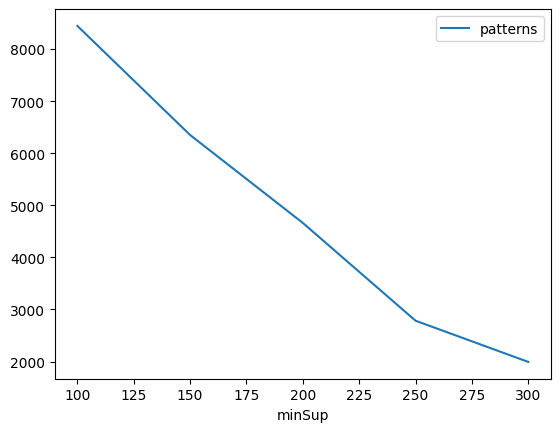

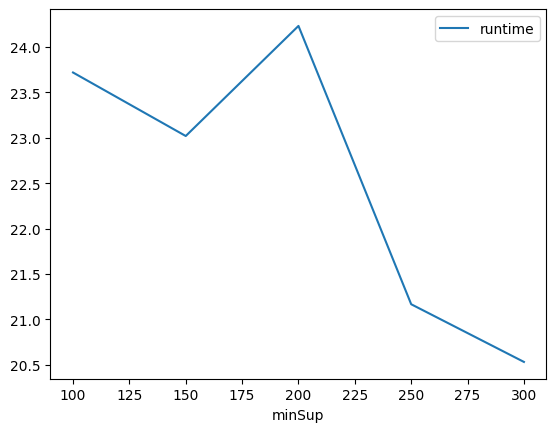

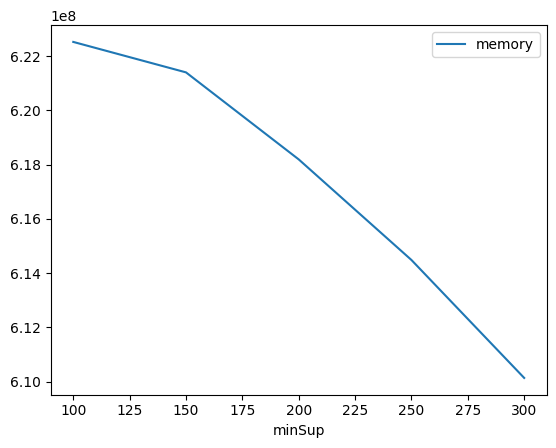

In [20]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib